In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

In [3]:
df = pd.read_excel("./app_build/MDSInc_sales.xlsx")
df.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,AG-2011-2040,2011-01-01 00:00:00,2011-06-01 00:00:00,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0,106.140,35.46,Medium
1,IN-2011-47883,2011-01-01 00:00:00,2011-08-01 00:00:00,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1,36.036,9.72,Medium
2,HU-2011-1220,2011-01-01 00:00:00,2011-05-01 00:00:00,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66,4,0.0,29.640,8.17,High
3,IT-2011-3647632,2011-01-01 00:00:00,2011-05-01 00:00:00,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",45,3,0.5,-26.055,4.82,High
4,IN-2011-47883,2011-01-01 00:00:00,2011-08-01 00:00:00,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",114,5,0.1,37.770,4.70,Medium


In [403]:
df["order_date"] = pd.to_datetime(df["order_date"])

In [404]:
cleaned_df = df.groupby(df["order_date"]).sum().reset_index()
cleaned_df = cleaned_df.drop(["order_date"], axis=1)
cleaned_df.head()

,sales,quantity,discount,profit,shipping_cost
0,808,19,0.80,198.8730,64.67
1,2457,54,1.35,603.4736,342.17
2,12567,177,5.94,1905.1539,1328.16
3,2586,86,6.00,-308.7874,376.49
4,11481,154,5.09,2460.2536,1209.56


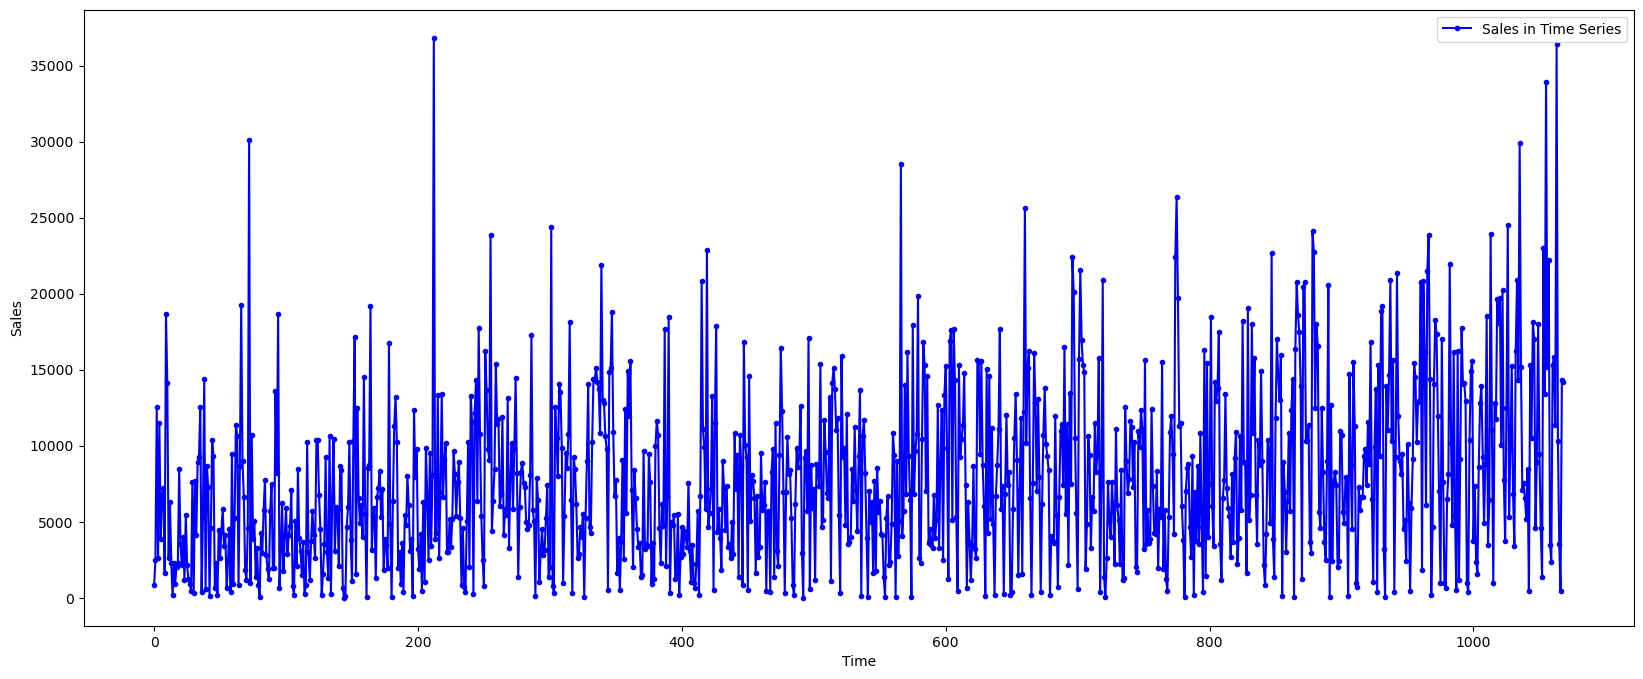

In [405]:
plt.figure(figsize=(20, 8))
plt.plot(cleaned_df.index, cleaned_df['sales'], 'b.-', label='Sales in Time Series')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()

In [420]:
model_df = StandardScaler().fit_transform(cleaned_df)
model_df[:2]

array([[-1.20648796, -1.2544257 , -1.0552996 , -0.59608424, -1.21002678],
       [-0.92212612, -0.77244973, -0.89871538, -0.25336693, -0.77397255]])

In [449]:
train_X, train_y = model_df, model_df[2:,:5]
train_X.shape,train_y.shape

((1069, 5), (1067, 5))

In [450]:
model = keras.Sequential()
model.add(layers.GRU(
    units = 128,
    input_shape =(2,5)
))
model.add(layers.Dense(units = 1))
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 128)               51840     
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 51969 (203.00 KB)
Trainable params: 51969 (203.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [451]:
full_n = train_y.shape[0]
n = int(train_y.shape[0]*0.7)

In [452]:
train = keras.preprocessing.timeseries_dataset_from_array(train_X[:n],train_y[:n],sequence_length=5,batch_size=1) #train
test = keras.preprocessing.timeseries_dataset_from_array(train_X[n:],train_y[n:],sequence_length=5,batch_size=1) #test
yet_test = keras.preprocessing.timeseries_dataset_from_array(train_X[n:n+10],train_y[n:n+10],sequence_length=5,batch_size=1)

In [453]:
test_x = np.array([i[0] for i in test])
test_x.resize(( full_n - n, 2, 5))

In [454]:
model.fit(train)
y_pred = model.predict(test_x)
y_pred.shape

11/11 [==============================] - 0s 697us/step


(321, 1)

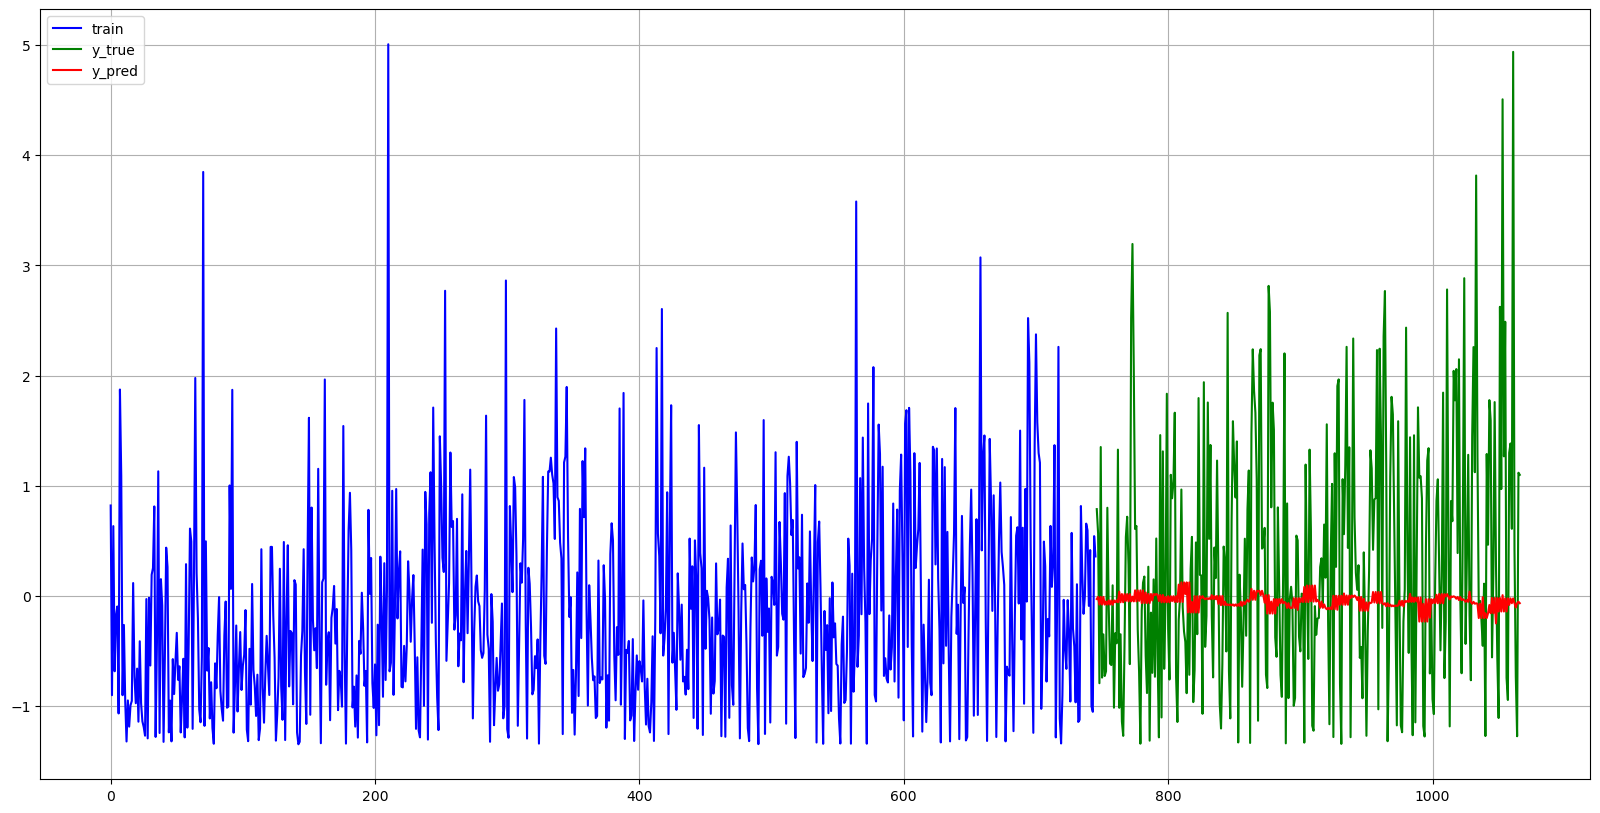

In [455]:
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n, 0],'b',label = 'train')
plt.plot(range(n,full_n),np.array(train_y)[n:, 0],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:, 0],'r',label = 'y_pred')
plt.legend()

In [448]:
[r2_score( np.array(train_y)[n:,i],y_pred[:,i]) for i in range(1)]

[-0.5380698827183983]

In [429]:
from sklearn.linear_model import LinearRegression

In [430]:
linear_model = LinearRegression()
linear_model.fit([ np.array(i[0]).flatten() for i in train],[np.array(i[0]).flatten() for i in train] )

LinearRegression()

In [431]:
y_pred  = linear_model.predict([np.array(i[0]).flatten() for i in test])
y_true = np.array([np.array(i[0]).flatten() for i in test])

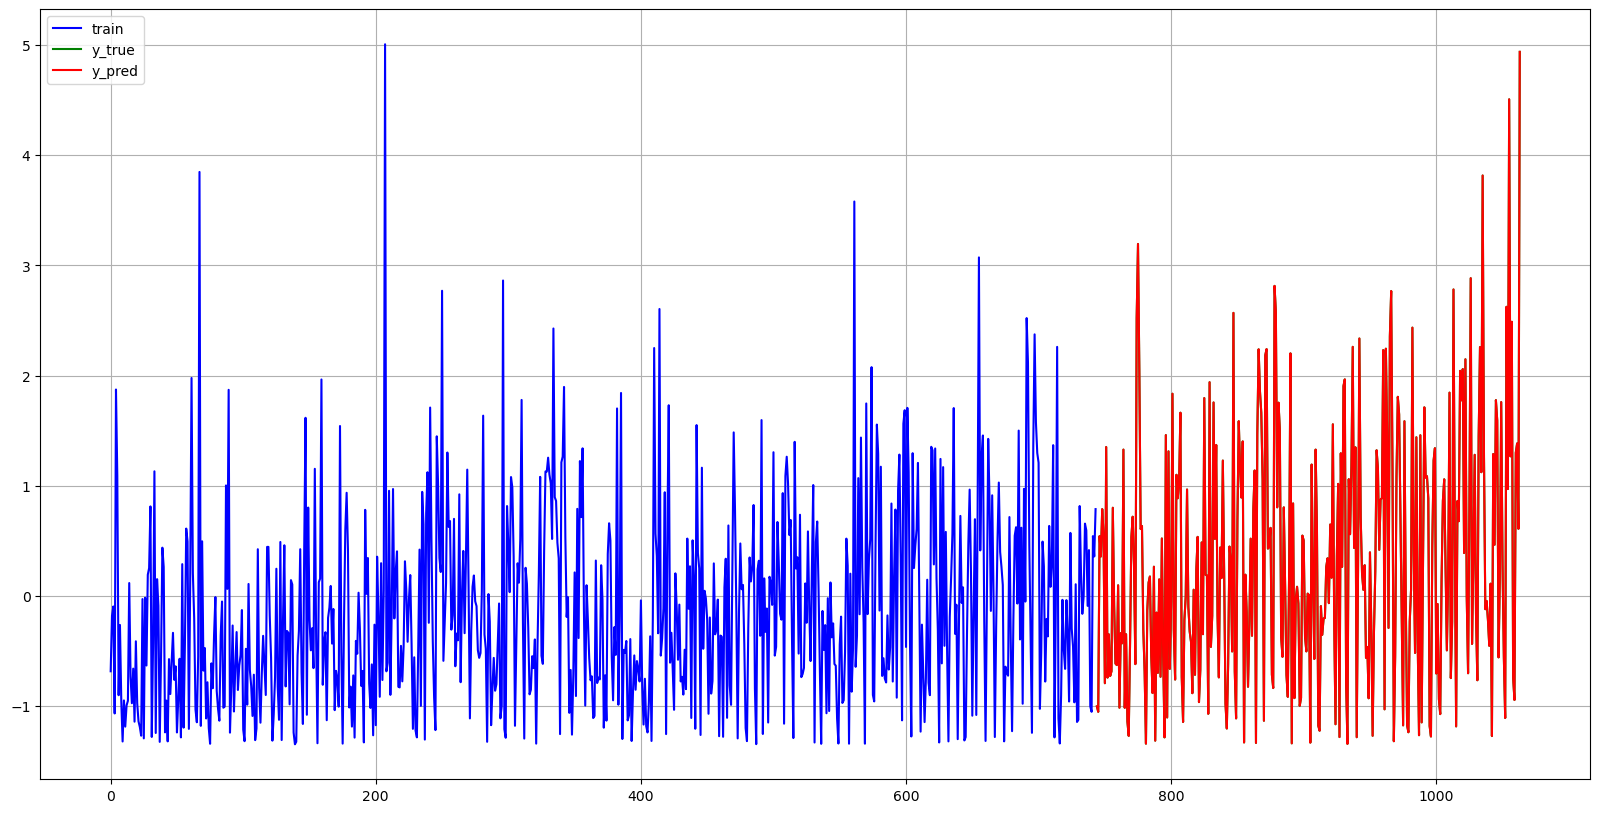

In [432]:
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n, 0],'b',label = 'train')
plt.plot(range(n,full_n), y_true[:, 0],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:, 0],'r',label = 'y_pred')
plt.legend()

In [433]:
linear_model = LinearRegression()
linear_model.fit([ np.array(i[0]).flatten() for i in train],[np.array(i[0]).flatten() for i in train] )

LinearRegression()

---